In [1]:
%load_ext autoreload
%autoreload

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Parameters tuning

In [2]:
gt = pd.read_csv('../../../dumps/various_sizes/8K.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

### Criterion

Measures the quality of a split. Two techniques are available : "*gini*" for the Gini impurty (default) and "*entropy*" for information gain.

In [3]:
for i in ["gini","entropy"]:
    print("Criterion : %s" % i)
    tree = DecisionTreeClassifier(criterion=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Criterion : gini
Accuracy on training set: 0.999
Accuracy on test set: 0.995
Criterion : entropy
Accuracy on training set: 0.999
Accuracy on test set: 0.989


We're clearly overfitting, nevertheless the *entropy* criteria seems to give slightly better results. Overfitting can be solved by limiting the depth of the tree (explained more deeply in a following section).

In [4]:
for i in ["gini","entropy"]:
    print("Criterion : %s" % i)
    tree = DecisionTreeClassifier(max_depth=4,criterion=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Criterion : gini
Accuracy on training set: 0.987
Accuracy on test set: 0.991
Criterion : entropy
Accuracy on training set: 0.991
Accuracy on test set: 0.991


In this case, the bith configuration give same results for the test set.

#### Splitter

The strategy used to choose the split at each node. Supported strategies are “*best*” to choose the best split (default) and “*random*” to choose the best random split. (N.B: we also apply depth limitation to avoid overfitting)

In [5]:
for i in ["best","random"]:
    print("Split strategy : %s" % i)
    tree = DecisionTreeClassifier(max_depth=4,splitter=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Split strategy : best
Accuracy on training set: 0.987
Accuracy on test set: 0.991
Split strategy : random
Accuracy on training set: 0.977
Accuracy on test set: 0.975


Looks like keeping the default splitter is also better in the case of this dataset.

#### Depth

Limiting the depth of the tree decreases overfitting. This leads to a lower accuracy on the training set, but an improvement on the test set:

In [6]:
for i in range(1,10):
    print("Depth set to %s" % i)
    tree = DecisionTreeClassifier(max_depth=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Depth set to 1
Accuracy on training set: 0.934
Accuracy on test set: 0.936
Depth set to 2
Accuracy on training set: 0.956
Accuracy on test set: 0.964
Depth set to 3
Accuracy on training set: 0.976
Accuracy on test set: 0.975
Depth set to 4
Accuracy on training set: 0.987
Accuracy on test set: 0.991
Depth set to 5
Accuracy on training set: 0.991
Accuracy on test set: 0.992
Depth set to 6
Accuracy on training set: 0.994
Accuracy on test set: 0.994
Depth set to 7
Accuracy on training set: 0.996
Accuracy on test set: 0.996
Depth set to 8
Accuracy on training set: 0.998
Accuracy on test set: 0.996
Depth set to 9
Accuracy on training set: 0.999
Accuracy on test set: 0.996


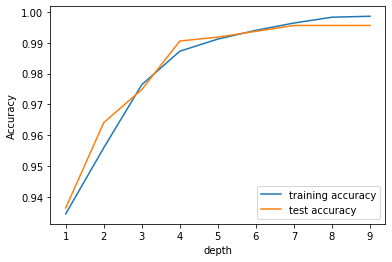

In [7]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 10)
for v in settings:
    clf = DecisionTreeClassifier(max_depth=v, random_state=0) 
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("depth")
plt.legend()

As we can see, increasing the depth value improves both accuracies until a certain point where the test results are constant. The best result we get starts at depth 7, which offers a good compromise between the two accuracies.

#### Minimum number of samples (split)

*min_samples_split* represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node.

In [8]:
for i in range(1,11):
    n_samples = i/10
    print("min_samples_split set to %s" % n_samples)
    tree = DecisionTreeClassifier(min_samples_split=n_samples, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 0.1
Accuracy on training set: 0.938
Accuracy on test set: 0.949
min_samples_split set to 0.2
Accuracy on training set: 0.938
Accuracy on test set: 0.949
min_samples_split set to 0.3
Accuracy on training set: 0.938
Accuracy on test set: 0.949
min_samples_split set to 0.4
Accuracy on training set: 0.938
Accuracy on test set: 0.949
min_samples_split set to 0.5
Accuracy on training set: 0.938
Accuracy on test set: 0.949
min_samples_split set to 0.6
Accuracy on training set: 0.938
Accuracy on test set: 0.949
min_samples_split set to 0.7
Accuracy on training set: 0.938
Accuracy on test set: 0.949
min_samples_split set to 0.8
Accuracy on training set: 0.938
Accuracy on test set: 0.949
min_samples_split set to 0.9
Accuracy on training set: 0.936
Accuracy on test set: 0.944
min_samples_split set to 1.0
Accuracy on training set: 0.934
Accuracy on test set: 0.936


In [10]:
for i in range(2,11):
    print("min_samples_split set to %s" % i)
    tree = DecisionTreeClassifier(min_samples_split=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 2
Accuracy on training set: 0.999
Accuracy on test set: 0.995
min_samples_split set to 3
Accuracy on training set: 0.999
Accuracy on test set: 0.995
min_samples_split set to 4
Accuracy on training set: 0.999
Accuracy on test set: 0.995
min_samples_split set to 5
Accuracy on training set: 0.999
Accuracy on test set: 0.994
min_samples_split set to 6
Accuracy on training set: 0.999
Accuracy on test set: 0.995
min_samples_split set to 7
Accuracy on training set: 0.999
Accuracy on test set: 0.995
min_samples_split set to 8
Accuracy on training set: 0.998
Accuracy on test set: 0.994
min_samples_split set to 9
Accuracy on training set: 0.998
Accuracy on test set: 0.995
min_samples_split set to 10
Accuracy on training set: 0.998
Accuracy on test set: 0.996


#### Minimum number of samples (leaf)

*min_samples_leaf* is the minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples at the leafs, the base of the tree.

In [11]:
for i in range(2,11):
    print("min_samples_split set to %s" % i)
    tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 2
Accuracy on training set: 0.997
Accuracy on test set: 0.996
min_samples_split set to 3
Accuracy on training set: 0.997
Accuracy on test set: 0.996
min_samples_split set to 4
Accuracy on training set: 0.996
Accuracy on test set: 0.996
min_samples_split set to 5
Accuracy on training set: 0.995
Accuracy on test set: 0.995
min_samples_split set to 6
Accuracy on training set: 0.995
Accuracy on test set: 0.997
min_samples_split set to 7
Accuracy on training set: 0.995
Accuracy on test set: 0.997
min_samples_split set to 8
Accuracy on training set: 0.993
Accuracy on test set: 0.994
min_samples_split set to 9
Accuracy on training set: 0.992
Accuracy on test set: 0.996
min_samples_split set to 10
Accuracy on training set: 0.991
Accuracy on test set: 0.994


#### Number of features

*max_features* represents the number of features to consider when looking for the best split. Since we're working with 119 different features, let's try all the values and see how relevant they are.

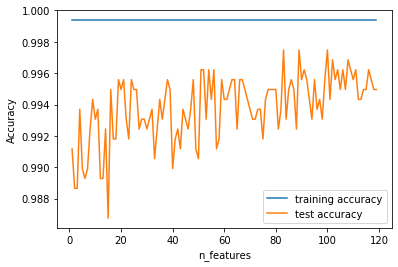

In [12]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 120)
for f in settings:
    clf = DecisionTreeClassifier(max_features=f, random_state=0) #n_jobs means that we use all processors
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_features")
plt.legend()

As we can see from the graph, not all features are important in making the classification. Further selection on relevant features will be made.

### Final choice

In [14]:
tree = DecisionTreeClassifier(max_depth=7,min_samples_split=10,min_samples_leaf=7,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.994
Accuracy on test set: 0.997
